In [85]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [86]:
# Paths to dataset directories
train_dir = "../Supervised/dataset/datasetsplitted/train"
val_dir = "../Supervised/dataset/datasetsplitted/val"
test_dir = "../Supervised/dataset/datasetsplitted/test"

# Parameters
IMG_SIZE = (128, 128)  # Use a smaller size for training efficiency
BATCH_SIZE = 32
EPOCHS = 25  # Increase for better performance

# Load datasets
train_dataset = image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_dataset = image_dataset_from_directory(val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

# Get class names and encode labels
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

label_encoder = LabelEncoder()
label_encoder.fit(class_names)

Found 2583 files belonging to 20 classes.
Found 323 files belonging to 20 classes.
Found 329 files belonging to 20 classes.
Found 20 classes: ['Golf', 'bmw serie 1', 'chevrolet spark', 'chevroulet aveo', 'clio', 'duster', 'hyundai i10', 'hyundai tucson', 'logan', 'megane', 'mercedes class a', 'nemo citroen', 'octavia', 'picanto', 'polo', 'sandero', 'seat ibiza', 'symbol', 'toyota corolla', 'volkswagen tiguan']


LabelEncoder()

In [87]:
# Normalize dataset
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [88]:
# Define a custom CNN model with explicit Input
def create_cnn():
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)  # Define functional model properly
    return model

cnn_model = create_cnn()
cnn_model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [89]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss doesn't improve
    patience=5,          # Wait 5 epochs before stopping
    restore_best_weights=True  # Restore the best model
)

In [90]:
# Train CNN with early stopping
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Add early stopping here
)


Epoch 1/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 52s 321ms/step - accuracy: 0.1112 - loss: 2.9143 - val_accuracy: 0.2136 - val_loss: 2.5891
Epoch 2/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.2757 - loss: 2.4170 - val_accuracy: 0.4056 - val_loss: 1.9033
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.5569 - loss: 1.4264 - val_accuracy: 0.6130 - val_loss: 1.1852
Epoch 4/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step - accuracy: 0.8357 - loss: 0.5576 - val_accuracy: 0.7028 - val_loss: 1.1537
Epoch 5/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 264ms/step - accuracy: 0.9364 - loss: 0.2079 - val_accuracy: 0.7276 - val_loss: 1.1284
Epoch 6/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - accuracy: 0.9692 - loss: 0.1124 - val_accuracy: 0.7276 - val_loss: 1.1560
Epoch 7/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.9819 - loss: 0.0620 - val_accuracy: 0.7585 - val_loss: 1.1678
Epoch 8/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - accuracy: 0.9913 - loss: 0.0339 - val_accu

In [91]:
# Extract Features from CNN
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)
def extract_features(dataset, feature_extractor):
    features, labels = [], []
    for images, lbls in dataset:
        features.append(feature_extractor.predict(images))
        labels.extend(lbls.numpy())
    return np.vstack(features), np.array(labels)
# Extract features for XGBoost
X_train, y_train = extract_features(train_dataset, feature_extractor)
X_val, y_val = extract_features(val_dataset, feature_extractor)
X_test, y_test = extract_features(test_dataset, feature_extractor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/s

In [92]:
# Train XGBoost classifier with early stopping
xgb_model = xgb.XGBClassifier(n_estimators=200, eval_metric='merror', max_depth=7, learning_rate=0.07)

In [93]:
# Use early stopping to prevent overfitting
xgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)],  # Monitor validation performance
    verbose=True
)
# Evaluate on test set
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


[0]	validation_0-merror:0.60062
[1]	validation_0-merror:0.53560
[2]	validation_0-merror:0.49536
[3]	validation_0-merror:0.47368
[4]	validation_0-merror:0.46749
[5]	validation_0-merror:0.44272
[6]	validation_0-merror:0.41176
[7]	validation_0-merror:0.40557
[8]	validation_0-merror:0.39628
[9]	validation_0-merror:0.38700
[10]	validation_0-merror:0.38080
[11]	validation_0-merror:0.37152
[12]	validation_0-merror:0.35294
[13]	validation_0-merror:0.34985
[14]	validation_0-merror:0.33746
[15]	validation_0-merror:0.33746
[16]	validation_0-merror:0.34056
[17]	validation_0-merror:0.32817
[18]	validation_0-merror:0.31579
[19]	validation_0-merror:0.30341
[20]	validation_0-merror:0.30650
[21]	validation_0-merror:0.29102
[22]	validation_0-merror:0.29102
[23]	validation_0-merror:0.29102
[24]	validation_0-merror:0.29102
[25]	validation_0-merror:0.29412
[26]	validation_0-merror:0.29721
[27]	validation_0-merror:0.29412
[28]	validation_0-merror:0.28793
[29]	validation_0-merror:0.28793
[30]	validation_0-me

In [94]:
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 0.8297872340425532
                   precision    recall  f1-score   support

             Golf       0.71      0.75      0.73        16
      bmw serie 1       1.00      0.67      0.80         9
  chevrolet spark       0.90      0.82      0.86        11
  chevroulet aveo       0.79      0.85      0.81        13
             clio       0.80      0.94      0.87        35
           duster       0.90      0.96      0.93        28
      hyundai i10       0.90      0.69      0.78        13
   hyundai tucson       0.92      0.85      0.88        13
            logan       1.00      0.92      0.96        12
           megane       0.73      0.86      0.79        28
 mercedes class a       1.00      0.89      0.94         9
     nemo citroen       0.75      0.75      0.75         8
          octavia       0.83      0.94      0.88        16
          picanto       0.67      1.00      0.80        18
             polo       1.00      0.57      0.73        14
          sandero       0.

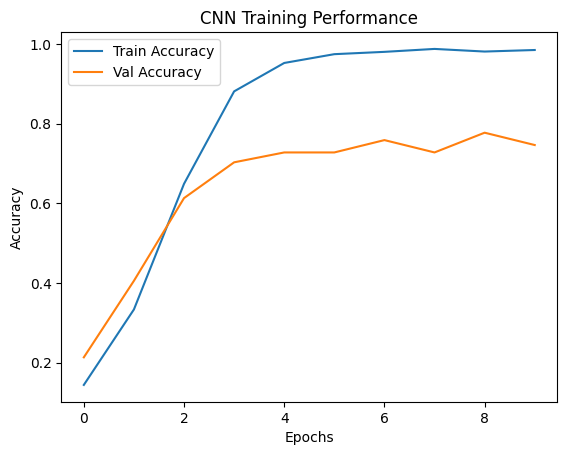

In [95]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Training Performance")
plt.show()
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

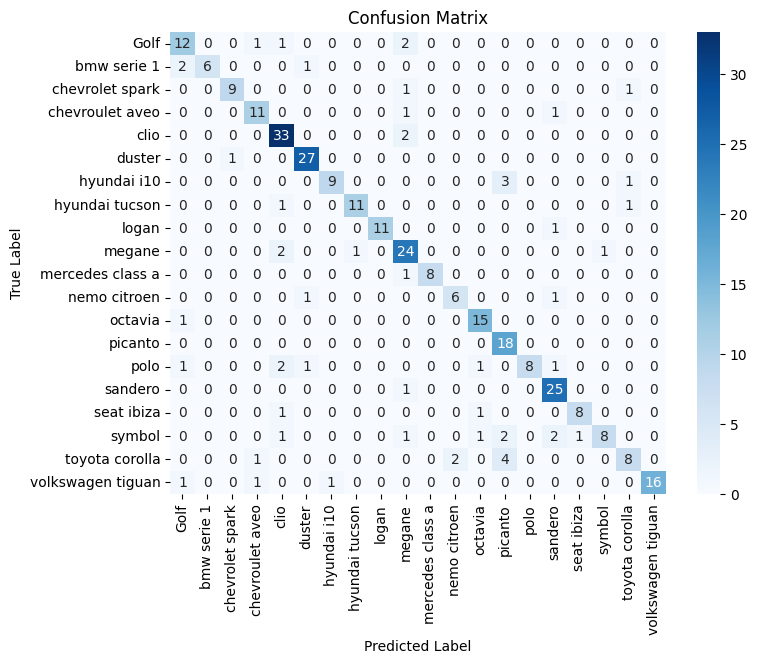

Hamming Distance: 0.1702127659574468


In [96]:

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
# Compute Hamming Distance
hamming_distance = np.mean(y_pred != y_test)
print(f"Hamming Distance: {hamming_distance}")
